## Using the Metropolis-Hastings algorithm to simulate observations from a multinormal distribution

Observations from a two-dimensional multinormal distribution are produced by simulation with the Metropolis-Hastings algorithm. The results are compared to SciPy's library implementation of multivariate normal distribution. 

This case study replicates an example found in the article *Understanding the Metropolis-Hastings Algorithm* by Chib and Greenberg [[1]](#1). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.random import RandomState
from scipy import stats

The code for the Metropolis-Hastings algorithm is inspired by Antti Honkela's lecture material for the course [Computational Statistics I](https://www.cs.helsinki.fi/u/ahonkela/teaching/compstats1/book/markov-chain-monte-carlo-basics.html#implementation-of-the-metropolis-hastings-algorithm).

In [2]:
def metropolis_hastings(uniform_rng, chain_start, n, logtarget, candidate_generating_density):
    x = chain_start
    chain = np.zeros(2 * n).reshape(2,n)
    accepted = 0
    
    for i in range(n):
        candidate = candidate_generating_density(x)
        
        if np.log(uniform_rng.uniform()) < logtarget(candidate) - logtarget(x):
            x = candidate
            accepted += 1
        
        chain[:,i] = x.reshape(2,)
        
    print(f"Percentage of proposals accepted: {(accepted/n)*100:.1f} %")
    return chain

Assume that the random vector $ (X, Y) $ is multivariate normally distributed. More specifically, assume that

$$\begin{bmatrix}
X \\ Y
\end{bmatrix}
\sim \mathcal{N}\left(
\begin{bmatrix}
1 \\ 2
\end{bmatrix},
\begin{bmatrix}
1 & 0.9 \\
0.9 & 1
\end{bmatrix}\right).$$

We want to simulate observations from this multivariate normal distribution. Since the covariance between $ X $ and $ Y $ is $ 0.9 $ and $$ Corr(X,Y) = \frac{Cov(X,Y)}{\sqrt{Var(X)}\sqrt{Var(Y)}} = \frac{0.9}{\sqrt{1} \times \sqrt{1}} = 0.9, $$ the values of $ X $ and $ Y $ are very strongly positively correlated. This fact will be readily apparent when the simulated observations are plotted.

In [3]:
rng = RandomState(1729)

mu = np.array([[1], [2]])
sigma = np.array([[1, 0.9], [0.9, 1]])
sigma_inverse = np.linalg.inv(sigma)

We initialize the logarithm of the density of the multivariate normal distribution. We omit the normalizing constant since it does not have an effect in the acceptance step of the Metropolis-Hastings algorithm.

In [4]:
logtarget = lambda x: -0.5 * np.transpose(x - mu) @ sigma_inverse @ (x - mu)

Next, we initialize an autoregressive generating density which is used to explore the state space. The autoregressive generating density proposes a move in the state space which the Metropolis-Hastings algorithm either accepts or rejects. This particular proposal density was one of the candidates discussed by Chib and Greenberg. The autoregressive density is reproduced exactly as it appeared in the article by Chib and Greenberg, even though it could be rewritten in a more compact way.

In [5]:
proposal_density = lambda x: mu - (x - mu) + rng.uniform(low=-1, high=1, size=2).reshape(2,1)

We start the Markov chain from the mean value of the multinormal distribution i.e. the point $ (1,2) $. The first half of the observations are discarded as the burn-in period. From the remaining observations only every tenth value is included in order to reduce the auto-correlation present in the sample.

In [6]:
chain = metropolis_hastings(rng, np.array([[1.0], [2.0]]), 100_000, logtarget, proposal_density)
print(f"Shape of chain {chain.shape}")

chain_without_burn_in = chain[:, chain.shape[1] // 2:]
print(f"Shape of chain after removing burn-in {chain_without_burn_in.shape}")

chain_with_gaps = chain_without_burn_in[:,::10]
print(f"Shape of chain after taking every 10th value in order to reduce auto-correlation {chain_with_gaps.shape}")

Percentage of proposals accepted: 46.9 %
Shape of chain (2, 100000)
Shape of chain after removing burn-in (2, 50000)
Shape of chain after taking every 10th value in order to reduce auto-correlation (2, 5000)


Next, we use the library implementation of SciPy's multinormal distribution to produce values for comparison.

In [7]:
scipy_multinormal = multivariate_normal.rvs(mean=mu.reshape(2,), cov=sigma, size=5000, random_state=RandomState(99)).T
print(scipy_multinormal.shape)

(2, 5000)


Finally, we can plot the two sets of observations. The strong positive autocorrelation is readily apparent as promised.

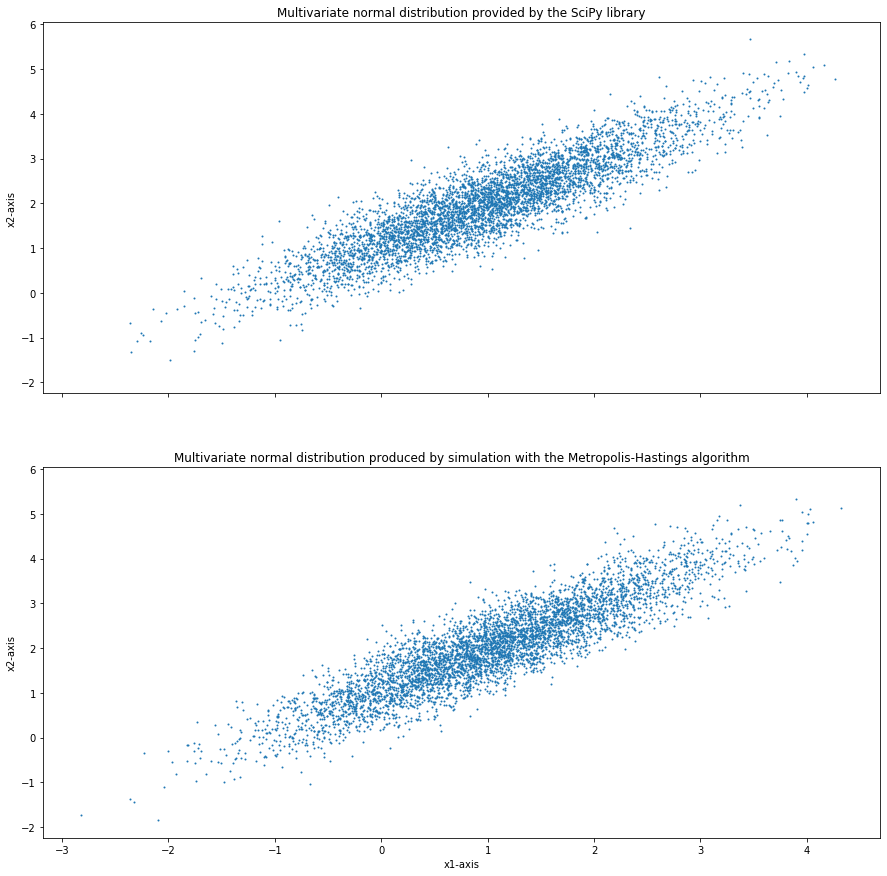

In [8]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

ax[0].scatter(scipy_multinormal[0], scipy_multinormal[1], s=1)
ax[0].set_title("Multivariate normal distribution provided by the SciPy library")

ax[1].scatter(chain_with_gaps[0,:], chain_with_gaps[1,:], s=1)
ax[1].set_title("Multivariate normal distribution produced by simulation with the Metropolis-Hastings algorithm")

for axis in ax.flat:
    axis.set(xlabel='x1-axis', ylabel='x2-axis')
    axis.label_outer()
    
plt.show()

From the plots we can see that the results are extremely similar.

# References

<a id="1">[1]</a>
Siddhartha Chib & Edward Greenberg (1995). Understanding the Metropolis-Hastings Algorithm. The American Statistician, 49:4, 327-335.